# Time Series Project

In [2]:
# yahoo finance

# %pip install yfinance

In [3]:
# import

import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from scipy.signal import find_peaks, periodogram

import sqlite3

# Preparing the Data

In [4]:
# set the ticker and date frame

ticker = "DAL"
start_date = "2022-04-01"
end_date = "2025-03-31"

In [5]:
# get the data

data = yf.download(ticker, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
# check the data

data

Price,Close,High,Low,Open,Volume
Ticker,DAL,DAL,DAL,DAL,DAL
Date,,,,,
2022-04-01,38.607456,39.186912,38.312815,38.961019,8606300
2022-04-04,38.695843,38.911908,38.018172,38.519059,9482700
2022-04-05,38.332462,39.157450,37.880684,38.803883,12713400
2022-04-06,36.918198,37.379799,36.063747,37.330690,16995200
2022-04-07,36.466412,36.829798,35.523566,36.702120,11688800
...,...,...,...,...,...
2025-03-24,48.880001,49.369999,47.700001,47.750000,9852900
2025-03-25,48.669998,49.990002,48.410000,49.599998,8227000


In [7]:
# remove multi-index

data = data.droplevel(level=1, axis=1).reset_index()
data

Price,Date,Close,High,Low,Open,Volume
0,2022-04-01,38.607456,39.186912,38.312815,38.961019,8606300
1,2022-04-04,38.695843,38.911908,38.018172,38.519059,9482700
2,2022-04-05,38.332462,39.157450,37.880684,38.803883,12713400
3,2022-04-06,36.918198,37.379799,36.063747,37.330690,16995200
4,2022-04-07,36.466412,36.829798,35.523566,36.702120,11688800
...,...,...,...,...,...,...
745,2025-03-24,48.880001,49.369999,47.700001,47.750000,9852900
746,2025-03-25,48.669998,49.990002,48.410000,49.599998,8227000
747,2025-03-26,48.070000,49.279999,47.509998,48.900002,6853200
748,2025-03-27,46.150002,48.000000,45.980000,47.520000,11157800


In [8]:
# create a new dataframe with just the date and close price

close = pd.DataFrame(columns=['Date', 'Close'])
close['Date'] = data['Date']
close['Close'] = data['Close']
close

,Date,Close
0,2022-04-01,38.607456
1,2022-04-04,38.695843
2,2022-04-05,38.332462
3,2022-04-06,36.918198
4,2022-04-07,36.466412
...,...,...
745,2025-03-24,48.880001
746,2025-03-25,48.669998
747,2025-03-26,48.070000
748,2025-03-27,46.150002


In [9]:
# make sure the data type of the Date column is datetime

close.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    750 non-null    datetime64[ns]
 1   Close   750 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.8 KB


In [10]:
# make the datetime the index

close = close.set_index('Date')
close

,Close
Date,
2022-04-01,38.607456
2022-04-04,38.695843
2022-04-05,38.332462
2022-04-06,36.918198
2022-04-07,36.466412
...,...
2025-03-24,48.880001
2025-03-25,48.669998
2025-03-26,48.070000


In [11]:
# auto detect the frequency of the datetime

inferred_freq = pd.infer_freq(close.index)
print(inferred_freq)

None


In [12]:
# manually set the frequency to business days, and fill missing dates with forward fill

close = close.asfreq('B')
close['Close'] = close['Close'].fillna(method='ffill')
close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 781 entries, 2022-04-01 to 2025-03-28
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   781 non-null    float64
dtypes: float64(1)
memory usage: 12.2 KB


/var/folders/bh/crnltg950_n8l07mfm97qdtc0000gn/T/ipykernel_2136/3438874196.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close['Close'] = close['Close'].fillna(method='ffill')


# Checking if the Data is Stationary

<Axes: xlabel='Date'>

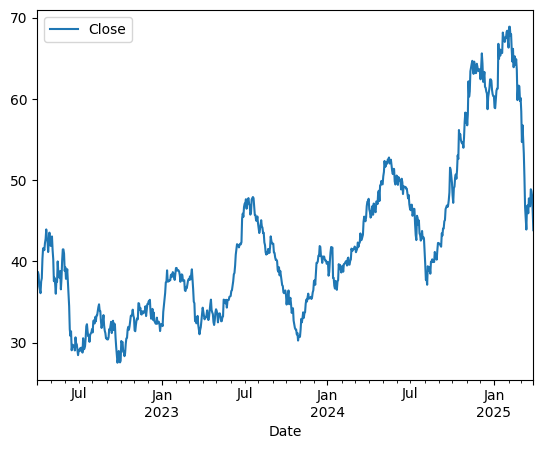

In [13]:
# plot the close prices

close.plot()

- the plot of the close prices show an upward trend in prices over time
- there is a vague pattern to the price increases and decreases, although it is difficult to tell if they repeat in a consistent manner or over what length of period of time
- I will calculate the rolling mean and standard deviations to confirm if the data is stationary

<Axes: xlabel='Date'>

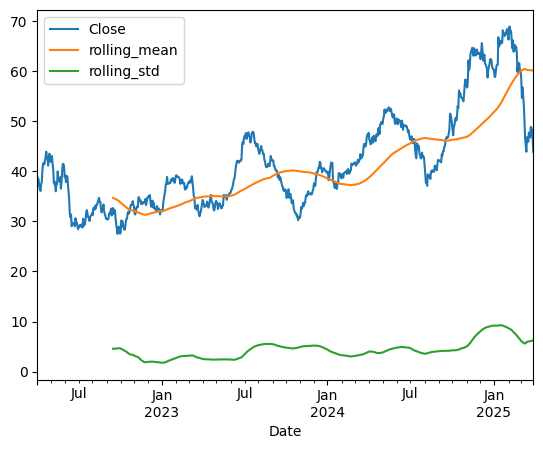

In [14]:
# calculate the rolling mean and rolling std

close['rolling_mean'] = close['Close'].rolling(120).mean()
close['rolling_std'] = close['Close'].rolling(120).std()

close.plot()

- the rolling mean shows a positive trend in the close price
- the rolling standard deviation also signals that the standard deviation is increasing over time
- based on the above, the data is not stationary. I will confirm this by using the ADFuller test
- the null hypothesis of the ADFuller test is that the data is not stationary, I would need a p value of less 0.05 in order to reject my null hypothesis

In [15]:
# use the ADFuller test to confirm that the data is not stationary

adfuller(close['Close'])

(-1.3715673096560288,
 0.5958286787798331,
 0,
 780,
 {'1%': -3.4387614757350087,
  '5%': -2.865252556432172,
  '10%': -2.5687469247205788},
 2085.9094027092515)

- the p-value of the ADF test is much greater than 0.05, which means I cannot reject the null hypothesis that the data is not stationary. 
- to make the data more stationary, I will remove non-constant variance by taking the log the close price, and then remove the trend by taking the difference of the logged close price. 

# Making the Data Stationary

<Axes: xlabel='Date'>

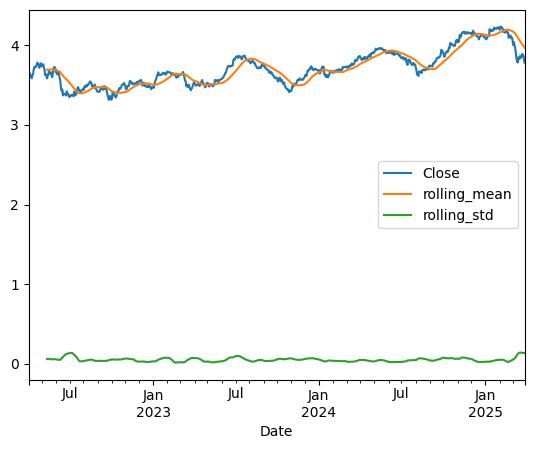

In [16]:
# create a copy of the dataframe with the log of the close price

close_log = close.copy()
close_log['Close'] = np.log(close_log['Close'])
close_log['rolling_mean'] = close_log['Close'].rolling(30).mean()
close_log['rolling_std'] = close_log['Close'].rolling(30).std()

close_log.plot()

- after taking the log of the close price, the variance is more consistent, but still increases over time 
- the rolling mean is also more stable, but there is still a slight upward trend

In [17]:
# check the adfuller p-value for the logged close price

adfuller(close_log['Close'])

(-1.4216577104917347,
 0.571850233638647,
 0,
 780,
 {'1%': -3.4387614757350087,
  '5%': -2.865252556432172,
  '10%': -2.5687469247205788},
 -3610.6804686964842)

- the p-value of the logged close price is again greater than 0.05, this means that I still cannot reject the null hypothesis that the data is not stationary. I will continue to make the data more stationary by taking different levels of differencing of the logged data. 

<Axes: xlabel='Date'>

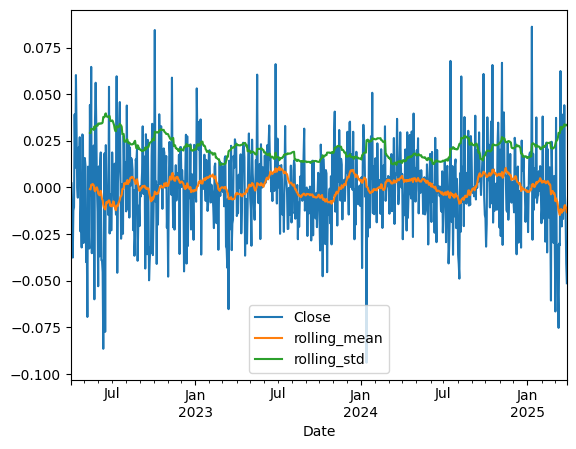

In [18]:
# create a copy of the dataframe with the log of the close price and 1 level of diff

close_log_diff = close.copy()
close_log_diff['Close'] = np.log(close_log_diff['Close']).diff()
close_log_diff['rolling_mean'] = close_log_diff['Close'].rolling(30).mean()
close_log_diff['rolling_std'] = close_log_diff['Close'].rolling(30).std()

close_log_diff.plot()

- the rolling mean and the rolling standard deviation both no longer have an obvious upward trend.
- I will check the adfuller p-value to see if the null hypothesis can be rejected or not.

In [19]:
# check the adfuller p-value on the logged close price with 1 level of difference

adfuller(close_log_diff['Close'].dropna())

(-18.26194729422899,
 2.3300338629843565e-30,
 1,
 778,
 {'1%': -3.438783171038672,
  '5%': -2.865262118650577,
  '10%': -2.568752018688748},
 -3604.280531021075)

- the p-value is very small, this means that we can reject the null hypothesis that the data is non-stationary. 
- I will continue to check additional levels of differencing

<Axes: xlabel='Date'>

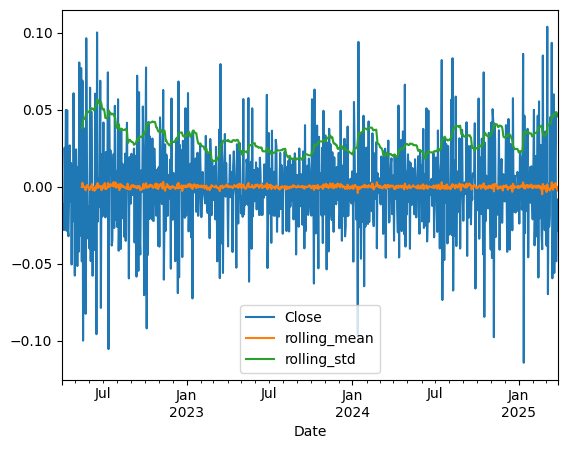

In [20]:
# create a copy of the dataframe with the log of the close price and 2 levels of diff

close_log_diff_diff = close.copy()
close_log_diff_diff['Close'] = np.log(close_log_diff_diff['Close']).diff().diff()
close_log_diff_diff['rolling_mean'] = close_log_diff_diff['Close'].rolling(30).mean()
close_log_diff_diff['rolling_std'] = close_log_diff_diff['Close'].rolling(30).std()

close_log_diff_diff.plot()

- at 2 levels of differencing, the rolling mean shows no trend at all, and the standard deviation does not show any overarching trends of increase or decrease.
- I will check the adfuller p-value to confirm. 

In [21]:
# check the adfuller p-value

adfuller(close_log_diff_diff['Close'].dropna())

(-10.628629251612757,
 5.284692635874217e-19,
 19,
 759,
 {'1%': -3.4389949984547465,
  '5%': -2.865355478124818,
  '10%': -2.568801753520772},
 -3553.080573180958)

- the p-value is very small, but greater than at 1 level of diff. Again, we can reject the null hypothesis that the data is not stationary. 
- since the p-value increased with 2 levels of diff, it means that the data already became stationary at 1 level of diff, and that additional levels of diff may or may not be unnecessary.

# Check for Seasonality

Differencing helps to alleviate seasonality, but the ADFuller test does not check for seasonality, so I will double check that there is no more seasonality left in the transformed data by using the following methods:
1. Seasonal decompose to visualize seasonality
2. Calculate the period of seasonality using periodogram

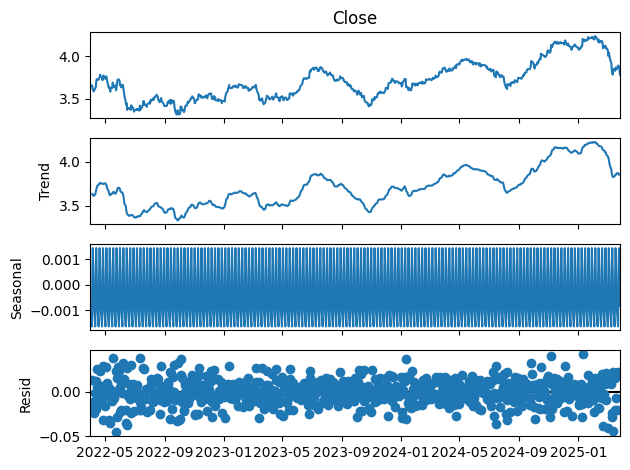

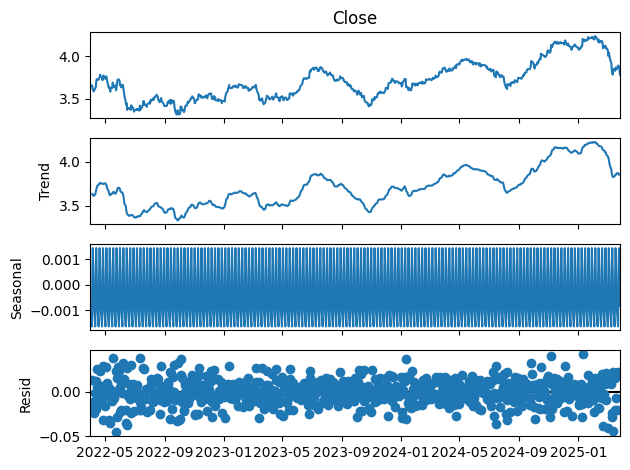

In [22]:
# use seasonal decompose to visualize any seasonality in the data

seasonal_results = seasonal_decompose(close_log['Close'].dropna())
seasonal_results.plot()

- The seasonal plot shows a repeating pattern, which indicates that there may be seasonality in the data. 
- I will next try to calculate the length of the seasonal period using perdiogram

In [23]:
# calculate the periods using periodogram

# compute the power spectrum
frequencies, power = periodogram(close_log['Close'].dropna())

# find peaks in the power specturm
peaks, _ = find_peaks(power, height=0.1 * max(power))

# convert frequency to period
periods = (1 / frequencies[peaks])

# return the period
periods

array([781.  , 195.25])

- the periods that the periodogram found significant are 781 and 195.25 business days. 
- 781 is the length of the data, so this indicates that there is an overarching trend across the entire time period
- 195.25 business days translate to roughly 275 days on the standard calendar, which is 3 quarters of a year
- I will next plot the periods to visualize the peaks in the frequencies

/var/folders/bh/crnltg950_n8l07mfm97qdtc0000gn/T/ipykernel_2136/1824241897.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot((1/frequencies), power)


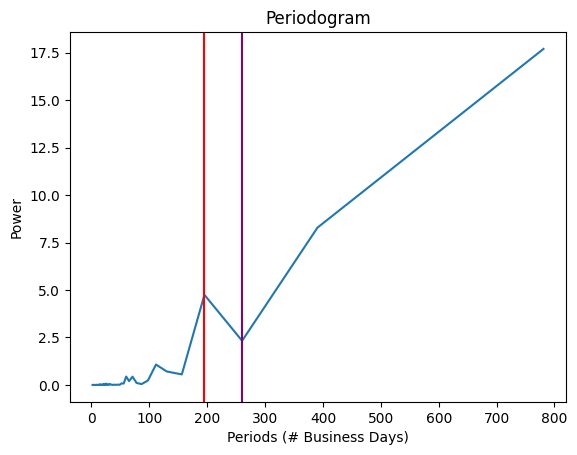

In [24]:
# plot the periods (1/frequencies)

plt.plot((1/frequencies), power)
plt.title("Periodogram")
plt.xlabel("Periods (# Business Days)")
plt.ylabel("Power")
plt.axvline(x=195.25, color='red');
plt.axvline(x=260, color='purple');

- the above plot shows the frequencies that were found by the power spectrum.
- there is a peak around 200, which correlates to the 195.25 found previously
- after 260, the power continues to increase, this is likely due to a trend in the data (which will be addressed through differencing)
- I will remove the seasonality next

# Removing Seasonality

<Axes: xlabel='Date'>

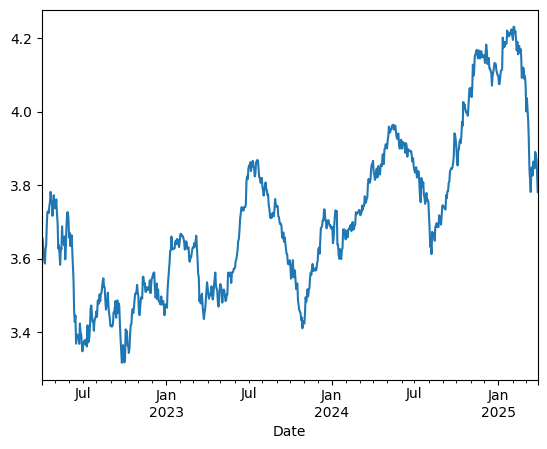

In [25]:
# save the seasonal element from the results

seasonal = seasonal_results.seasonal

# remove the seasonality by subtracting it from the close prices

close_log_season = close_log.copy()
close_log_season['Close'] = (close_log['Close'] - seasonal)
close_log_season['Close'].plot()

### Analyze the ACF and PACF plots for best p, d, q

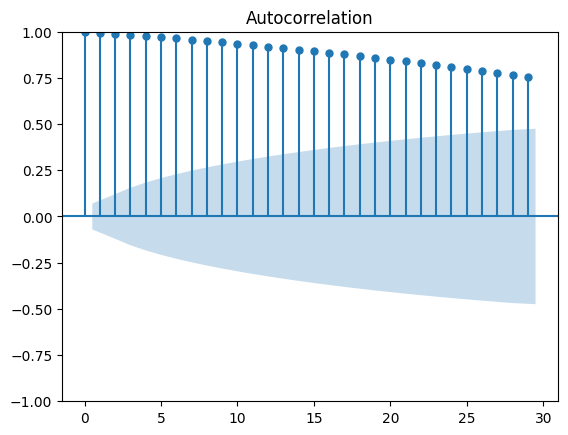

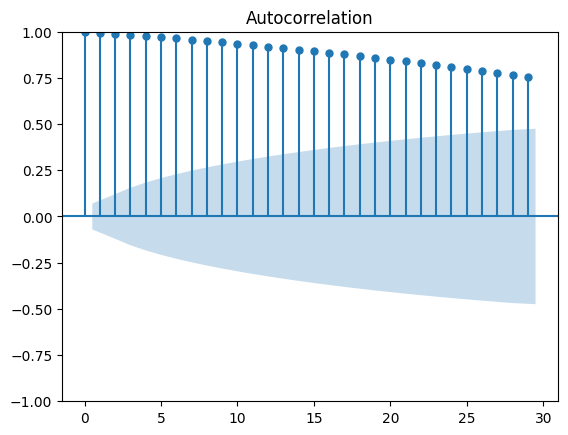

In [26]:
# plot the acf with the log-transformed data and seasonality removed

plot_acf(close_log_season['Close'].dropna())

- the gradually decreasing ACF plot indicates autoregressive characteristics which means that there are predictable patterns based on past values. This confirms that I should consider AR terms in my model.

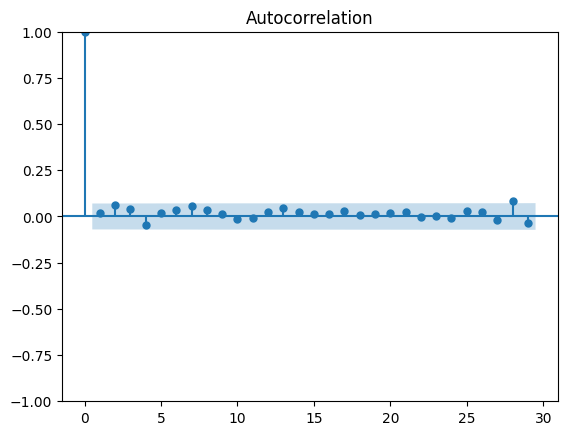

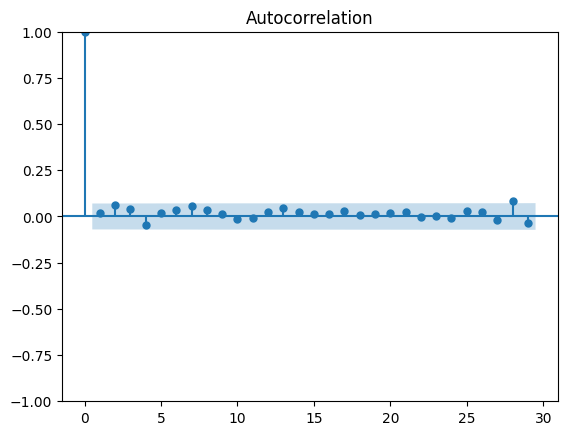

In [27]:
# plot the acf with 1 level of diff

plot_acf(close_log_season['Close'].diff().dropna())

- The ACF shows no significant autocorrelation after lag of 0. 
- This suggests that when using 1 level of diff the MA component in the ARIMA model may be 0 (q = 0). 

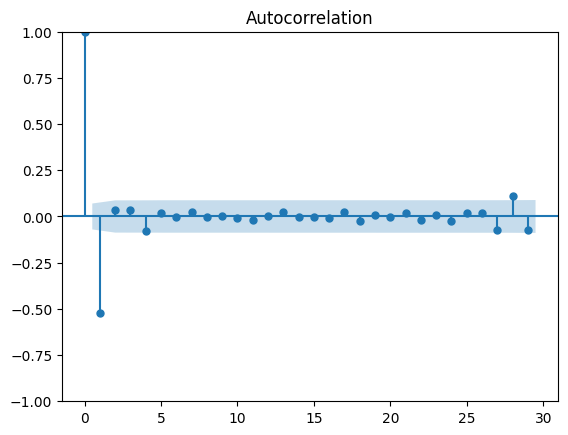

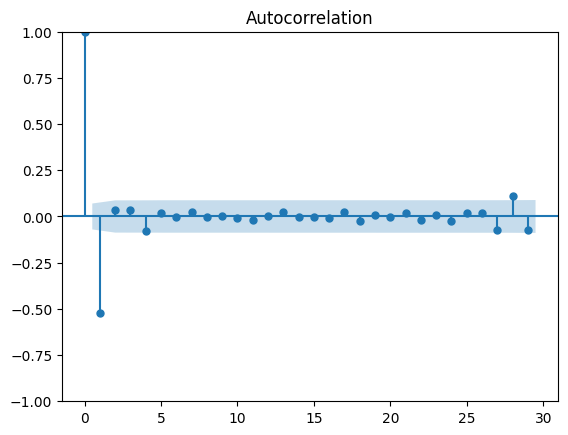

In [28]:
# plot the acf with 2 levels of diff

plot_acf(close_log_season['Close'].diff().diff().dropna())

- The ACF shows no significant autocorrelation after lag of 1. 
- This suggests that when using 2 levels of diff, the MA component in the ARIMA model may be 1 (q = 1). 

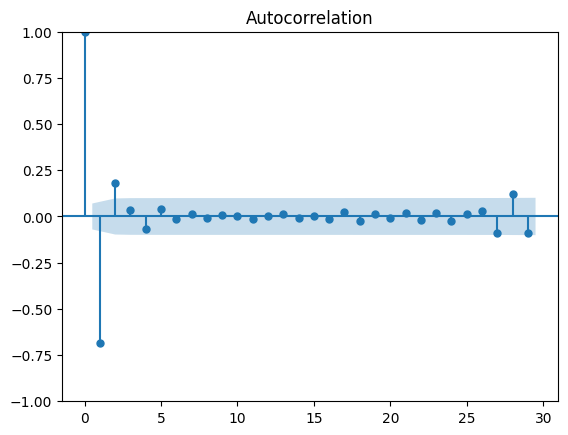

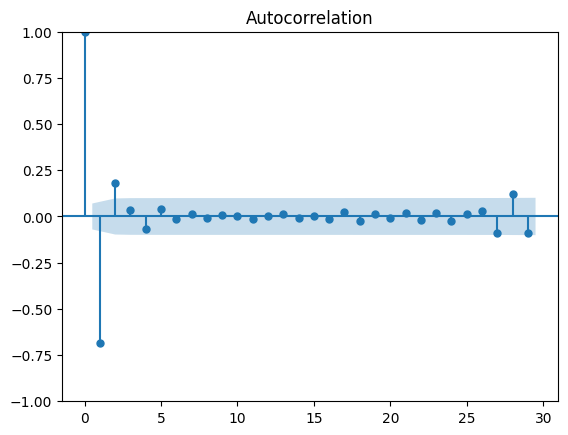

In [29]:
# plot the acf with 3 levels of diff

plot_acf(close_log_season['Close'].diff().diff().diff().dropna())

- The ACF shows no significant autocorrelation after lag of 2. 
- This suggests that when using 3 levels of diff, the MA component in the ARIMA model may be 2 (q = 2). 

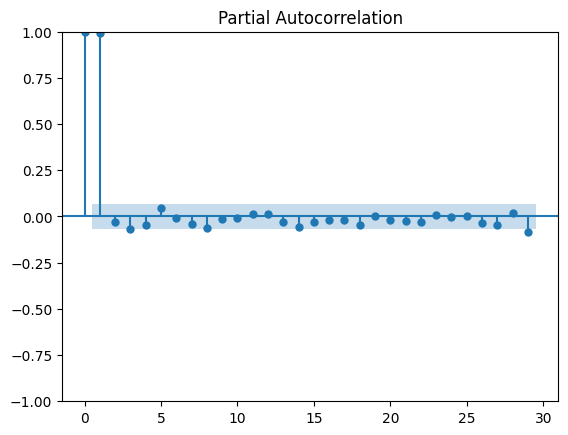

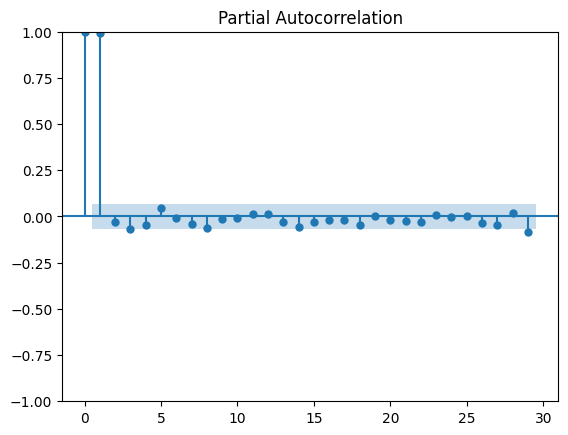

In [30]:
# plot the pacf

plot_pacf(close_log_season['Close'].dropna())

- With no differencing, the PACF shows a significant drop after lag 1, suggesting that the AR component in the ARIMA model may be 1 (p = 1). 

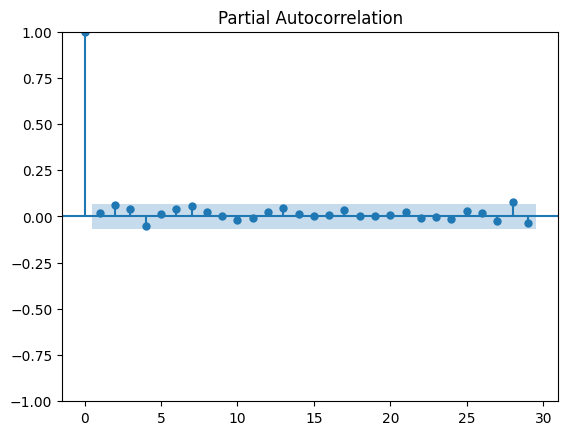

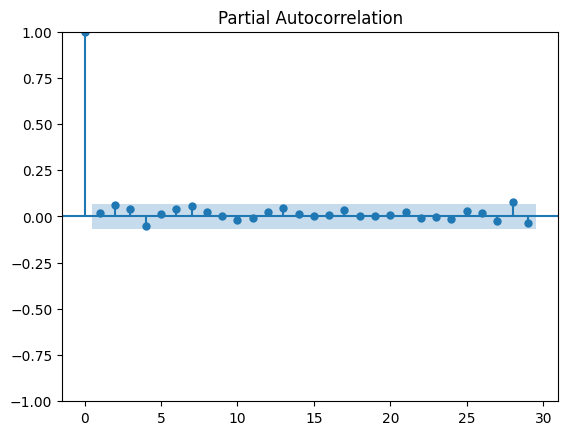

In [31]:
# plot the pacf with 1 level of diff

plot_pacf(close_log_season['Close'].diff().dropna())

- With 1 level of differencing, the PACF shows no significant autocorrelation after lag 0, suggesting that the AR component in the ARIMA model may be 0 (p = 0). 

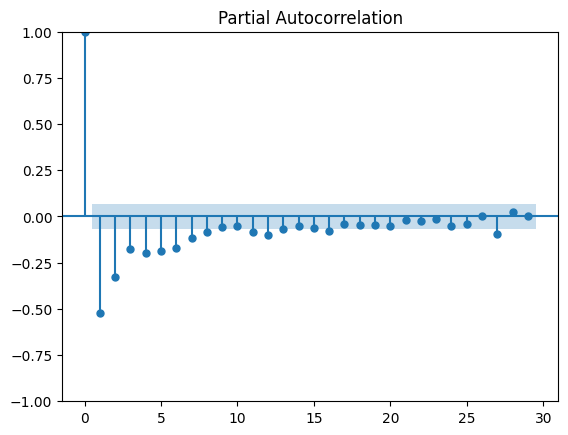

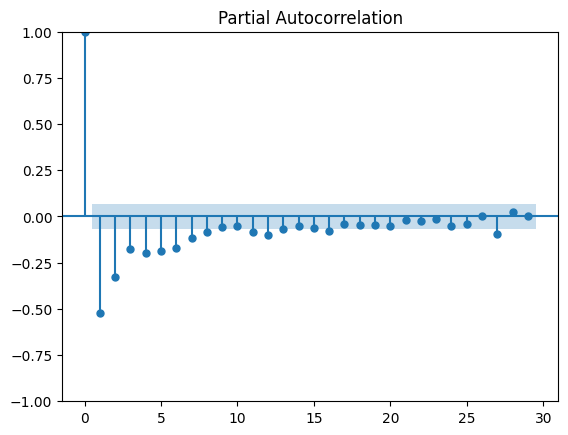

In [32]:
# plot the pacf with 2 levels of diff

plot_pacf(close_log_season['Close'].diff().diff().dropna())

- With 2 levels of differencing, the PACF shows significant autocorrelation up to lag 7, suggesting that the AR component in the ARIMA model may be 7 (p = 7). 

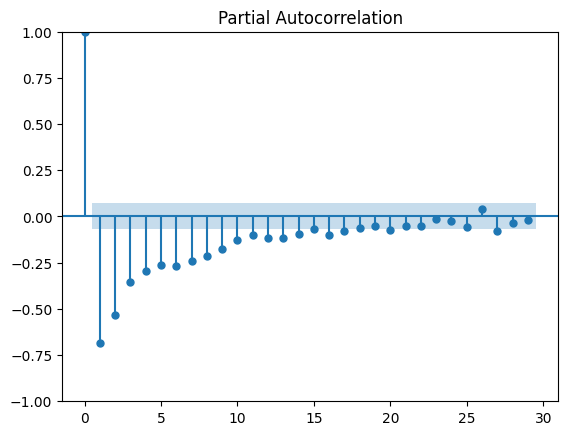

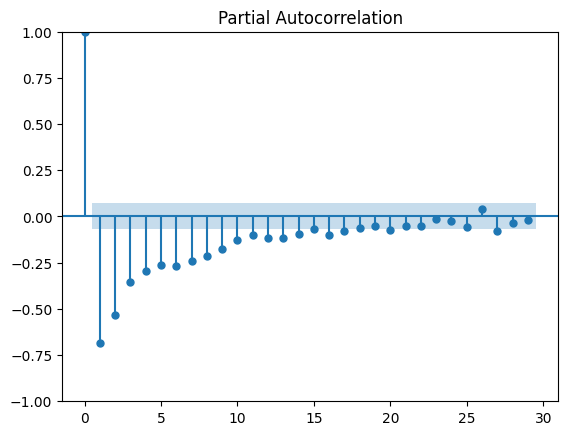

In [33]:
# plot the pacf with 3 levels of diff

plot_pacf(close_log_season['Close'].diff().diff().diff().dropna())

- With 3 levels of differencing, the PACF shows significant autocorrelation up to lag 17, suggesting that the AR component in the ARIMA model may be 17 (p = 17). 

### Based on the ACF and PACF plots, my best hyperparameters are q=1, d=2, p=7

# ARIMA Model

In [34]:
# train test split

train, test = train_test_split(close_log_season['Close'], test_size=60, shuffle=False)

display(train.tail())
display(test.head())

Date
2024-12-30    4.105473
2024-12-31    4.099724
2025-01-01    4.098770
2025-01-02    4.075754
2025-01-03    4.075930
Freq: B, Name: Close, dtype: float64

Date
2025-01-06    4.094211
2025-01-07    4.110901
2025-01-08    4.113863
2025-01-09    4.114766
2025-01-10    4.202338
Freq: B, Name: Close, dtype: float64

In [35]:
# set my best hyperparameters based on the acf and pacf plots

q = 1
d = 2
p = 7

# define the ARIMA model

model7_2_1 = ARIMA(train, order=(p,d,q))
results_model7_2_1 = model7_2_1.fit()

# check the results summary

results_model7_2_1.summary()

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  721
Model:                 ARIMA(7, 2, 1)   Log Likelihood                1715.990
Date:                Thu, 03 Apr 2025   AIC                          -3413.980
Time:                        14:15:12   BIC                          -3372.779
Sample:                    04-01-2022   HQIC                         -3398.073
                         - 01-03-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2281      0.076     -2.995      0.003      -0.377      -0.079
ar.L2         -0.1641      0.070     -2.335      0.020      -0.302      -0.026
ar.L3         -0.1732      0.067     -2.594      0.009      -0.304      -0.042
ar.L4         -0.2125      0.054     -3.908      0.000      -0.319      -0.106
ar.L5         -0.1569      0.048     -3.261      0.001      -0.251      -0.063
ar.L6         -0.1087      0.054     -2.021      0.043      -0.214      -0.003
ar.L7         -0.0951      0.045     -2.135      0.033      -0.182      -0.008
ma.L1         -0.7139      0.067    -10.625      0.000      -0.846      -0.582
sigma2         0.0005   2.18e-05     22.957      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                72.25
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The SARIMAX results:
1. Ljung-Box prob(Q) is high, which means that there are no significant autocorrelations left in the residuals
2. Jarque-Bera prob(JB) is low, indicating that residuals are not normally distributed, which can affect confidence intervals, but forecasting models may still work well 
3. Heteroskedasticity prob(H) is also low, which indicates that heteroskedasticity is still present

- Next, I will evaluate the model by predicting test and calculating the RMSE

(14292.0, 14351.0)

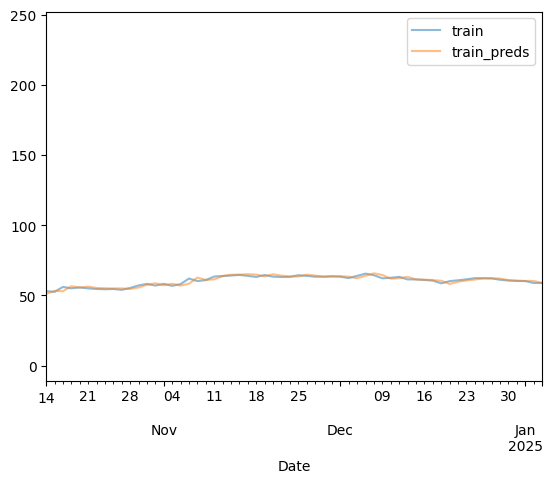

In [36]:
# get the predictions

train_preds_model7_2_1 = results_model7_2_1.fittedvalues

# build a df to store predictions

results_model7_2_1_train = pd.DataFrame(columns=['train','train_preds'])
results_model7_2_1_train['train'] = np.exp(train)
results_model7_2_1_train['train_preds'] = np.exp(train_preds_model7_2_1)
results_model7_2_1_train.plot(alpha = 0.5)
plt.xlim(train.index[-60], train.index[-1])

<Axes: xlabel='Date'>

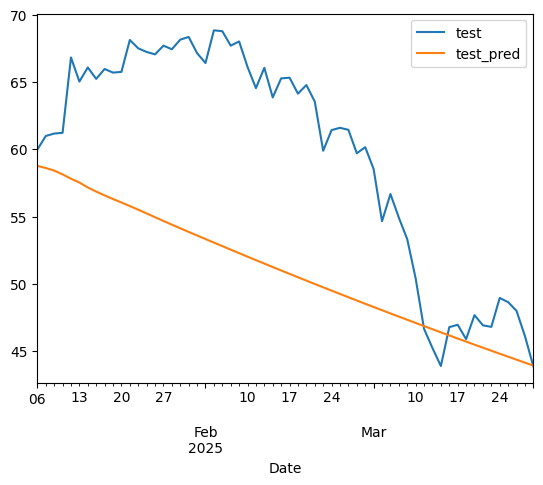

In [37]:
# forecasting test

forecast_60_days = results_model7_2_1.forecast(steps=len(test))
forecast_60_days

test_results_model7_2_1 = pd.DataFrame(columns=['test','test_pred'])
test_results_model7_2_1['test'] = np.exp(test)
test_results_model7_2_1['test_pred'] = np.exp(forecast_60_days)
test_results_model7_2_1.plot()

In [38]:
# calculate the metrics for the model
print('Train RMSE', root_mean_squared_error(results_model7_2_1_train['train'],
                                            results_model7_2_1_train['train_preds']))
print('Test RMSE', root_mean_squared_error(test_results_model7_2_1['test'],
                                           test_results_model7_2_1['test_pred']))

Train RMSE 7.682202722292414
Test RMSE 10.160941938238034


- The RMSE is lower on train than on test, this indicates the model is overfit
- I will try to improve the model by using AutoARIMA to search for the best hyperparameters

# Using AutoARIMA to search for the best hyperparameters

In [39]:
# import pmdarima

import pmdarima as pm

In [40]:
# set the search parameters

pmarima = pm.AutoARIMA(start_p=0, max_p=5,
                       start_q=0, max_q=5,
                       start_P=0, max_P=2,
                       start_Q=0, max_Q=2,
                       start_d=0, max_d=2,
                       start_D=0, max_D=2,
                       seasonal=True, random=True, n_fits=20,
                       random_state=42, with_intercept=True, stepwise=False, suppress_warnings=True,
                       error_action='ignore', trace=True, m=21)


In [41]:
# fit the model

pmarima.fit(train)

# get the best model
model=pmarima.model_
model.summary()

 ARIMA(2,1,3)(0,0,0)[21] intercept   : AIC=-3464.977, Time=0.59 sec
 ARIMA(2,1,2)(0,0,0)[21] intercept   : AIC=-3467.495, Time=0.26 sec
 ARIMA(2,1,1)(0,0,2)[21] intercept   : AIC=-3464.520, Time=13.96 sec
 ARIMA(4,1,1)(0,0,0)[21] intercept   : AIC=-3465.173, Time=0.27 sec
 ARIMA(0,1,4)(0,0,1)[21] intercept   : AIC=-3466.480, Time=3.75 sec
 ARIMA(2,1,2)(1,0,0)[21] intercept   : AIC=-3466.523, Time=5.04 sec
 ARIMA(2,1,0)(2,0,0)[21] intercept   : AIC=-3466.617, Time=13.54 sec
 ARIMA(1,1,0)(2,0,0)[21] intercept   : AIC=-3466.503, Time=1.61 sec
 ARIMA(0,1,0)(0,0,0)[21] intercept   : AIC=-3471.166, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[21] intercept   : AIC=-3468.430, Time=1.69 sec
 ARIMA(2,1,0)(0,0,1)[21] intercept   : AIC=-3468.562, Time=2.28 sec
 ARIMA(0,1,3)(1,0,1)[21] intercept   : AIC=-3464.964, Time=2.21 sec
 ARIMA(0,1,2)(0,0,0)[21] intercept   : AIC=-3469.693, Time=0.13 sec
 ARIMA(0,1,0)(1,0,1)[21] intercept   : AIC=-3468.196, Time=2.01 sec
 ARIMA(0,1,3)(2,0,0)[21] intercept   : AIC=-34

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  721
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1737.583
Date:                Thu, 03 Apr 2025   AIC                          -3471.166
Time:                        14:16:12   BIC                          -3462.007
Sample:                    04-01-2022   HQIC                         -3467.630
                         - 01-03-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.725      0.469      -0.001       0.002
sigma2         0.0005   1.89e-05     24.847      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                62.61
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- the best model from the autoARIMA search is (0,1,0), which only uses differencing, and no autoregressive or moving average terms.

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_d', 'start_D']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


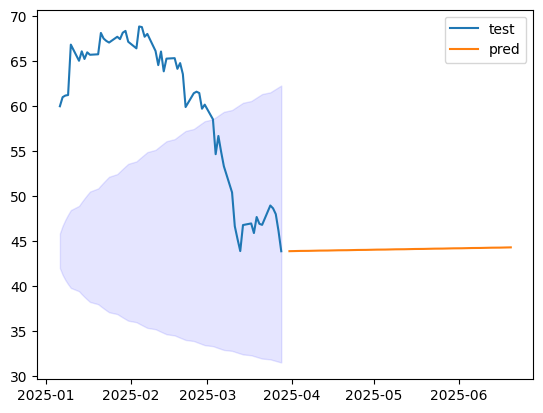

In [57]:
# get the predictions from the best model

pm_test_pred, confs = model.predict(n_periods=len(test), return_conf_int=True)

# plot the predictions

plt.plot(np.exp(test), label='test')
plt.plot(np.exp(pm_test_pred), label='pred')
plt.fill_between(test.index, np.exp(confs[:,0]), np.exp(confs[:,1]), color='blue', alpha=.1)
plt.legend()

- the model is predicting a constant price

In [58]:
# store the test predictions

pm_test_preds = pd.DataFrame(columns=['test','test_preds'])
pm_test_preds['test'] = np.exp(test)
pm_test_preds['test_preds'] = np.exp(pm_test_pred)


In [59]:
# get the train predictions

pm_train_pred = model.predict_in_sample()

In [60]:
# store the train predictions

pm_train_preds = pd.DataFrame(columns=['train','train_preds'])
pm_train_preds['train'] = np.exp(train)
pm_train_preds['train_preds'] = np.exp(pm_train_pred)

In [61]:
# calculate the metrics for the model

print('Train RMSE', root_mean_squared_error(pm_train_preds['train'], pm_train_preds['train_preds']))
print('Test RMSE', root_mean_squared_error(pm_test_preds['test'], pm_test_preds['test_preds']))

Train RMSE 1.6457361340666308


ValueError: Input contains NaN.

- the RMSE for the autoARIMA's best model is lower than the RMSE of the model with manually select hyperparameters. However, the autoARIMA's train RMSE is much lower than that of test's, which indicates that the model is extremely overfit. 

# Modeling using Prophet

In [ ]:
from prophet import Prophet

# create a model
m = Prophet()
prophet_train = np.exp(train).reset_index()

# rename the columns to ds and y
prophet_train.columns = ['ds', 'y']
prophet_train

# fit the data
m.fit(prophet_train)

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
14:16:12 - cmdstanpy - INFO - Chain [1] start processing
14:16:12 - cmdstanpy - INFO - Chain [1] done processing


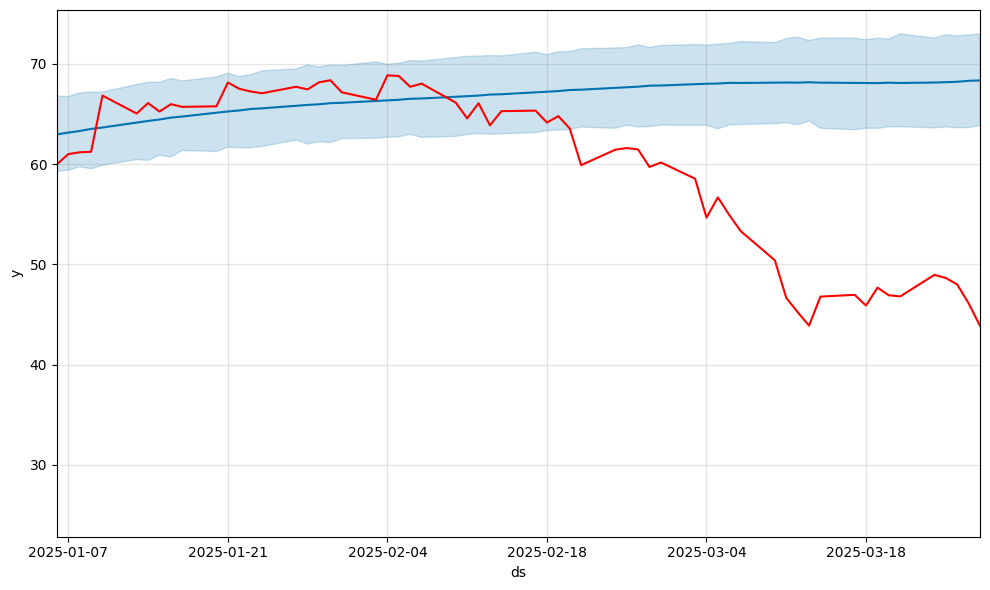

In [ ]:
# make a future dataframe

future = m.make_future_dataframe(periods=len(test), freq='B')
forecast = m.predict(future)
m.plot(forecast)
plt.xlim(test.index[0], test.index[-1])
plt.plot(np.exp(test), label='test', color='red');

In [ ]:
# save the predictions for only the test time period
m_test_preds = [forecast.loc[forecast['ds'] == month, 'yhat'].values[0] for month in test.index]

# save the predictions in a dataframe
m_test_results = pd.DataFrame(columns = ['test', 'm_test_pred'])
m_test_results['test'] = np.exp(test)
m_test_results['m_test_pred'] = m_test_preds

# get the metrics for the Prophet model
print('RMSE', root_mean_squared_error(m_test_results['test'], m_test_results['m_test_pred']))


RMSE 11.60422722445134


# Predicting prices for the future

 ARIMA(2,1,3)(0,0,0)[21] intercept   : AIC=-3702.003, Time=0.88 sec
 ARIMA(2,1,2)(0,0,0)[21] intercept   : AIC=-3703.681, Time=0.30 sec
 ARIMA(2,1,1)(0,0,2)[21] intercept   : AIC=-3699.431, Time=3.58 sec
 ARIMA(4,1,1)(0,0,0)[21] intercept   : AIC=-3701.836, Time=0.13 sec
 ARIMA(0,1,4)(0,0,1)[21] intercept   : AIC=-3703.094, Time=3.30 sec
 ARIMA(2,1,2)(1,0,0)[21] intercept   : AIC=-3702.326, Time=5.96 sec
 ARIMA(2,1,0)(2,0,0)[21] intercept   : AIC=-3701.786, Time=5.23 sec
 ARIMA(1,1,0)(2,0,0)[21] intercept   : AIC=-3701.073, Time=3.91 sec
 ARIMA(0,1,0)(0,0,0)[21] intercept   : AIC=-3705.292, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[21] intercept   : AIC=-3702.190, Time=1.65 sec
 ARIMA(2,1,0)(0,0,1)[21] intercept   : AIC=-3703.006, Time=2.52 sec
 ARIMA(0,1,3)(1,0,1)[21] intercept   : AIC=-3700.669, Time=3.27 sec
 ARIMA(0,1,2)(0,0,0)[21] intercept   : AIC=-3704.583, Time=0.09 sec
 ARIMA(0,1,0)(1,0,1)[21] intercept   : AIC=-3702.076, Time=1.37 sec
 ARIMA(0,1,3)(2,0,0)[21] intercept   : AIC=-3701

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_d', 'start_D']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


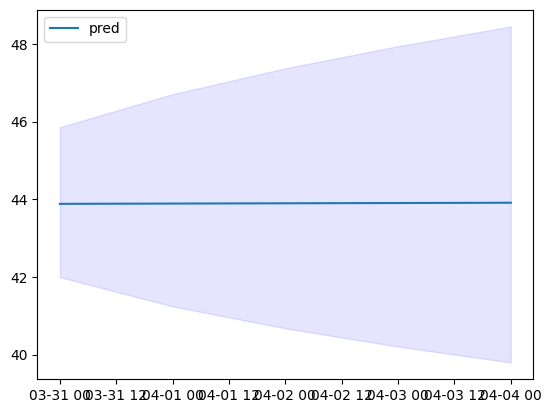

In [ ]:
# use the best model from the autoARIMA to predict future prices
# re-fit the model on the most recent data
pmarima.fit(close_log_season['Close'])

# get the best model
model=pmarima.model_

# make predictions for the next 5 days
future_preds_5, confs = model.predict(n_periods=5, return_conf_int=True)

# plot the predictions

plt.plot(np.exp(future_preds_5), label='pred')
plt.fill_between(future_preds_5.index, np.exp(confs[:,0]), np.exp(confs[:,1]), color='blue', alpha=.1)
plt.legend()

In [ ]:
# get the predict prices

future_preds_5_exp = np.exp(future_preds_5)

# Save the predictions to a database

In [ ]:
# save the predictions to csv

future_preds_5_exp.to_csv('future_preds_5', index=True)

In [ ]:
# create a new sqlite connection

conn = sqlite3.connect('yfinance.db')

In [ ]:
# save the predictions to sql database

future_preds_5_exp.to_sql('future_preds_5', conn, index=True, if_exists='replace')

5

In [ ]:
# read from sql table to double check

future_preds_from_sql = pd.read_sql('SELECT * FROM future_preds_5', conn)
future_preds_from_sql

,index,0
0,2025-03-31 00:00:00,43.883385
1,2025-04-01 00:00:00,43.890536
2,2025-04-02 00:00:00,43.897688
3,2025-04-03 00:00:00,43.904841
4,2025-04-04 00:00:00,43.911995


In [ ]:
# close the sql connection

conn.close()